# exp045_train_cv

In [65]:
MODE = 'local_train'
#MODE = 'kaggle_inference'

In [66]:
exp_name = 'exp045'
memo = 'exp043 + 特徴量に1stのrank追加'

In [67]:
import os
import sys
import gc

if MODE == 'local_train':
    sys.path.append('/home/kaggler/.local/lib/python3.8/site-packages')
    from dotenv import load_dotenv
    load_dotenv
    sys.path.append(os.getenv('UTILS_PATH'))
    import line_notify
    import slack_notify
    

from cuml import ForestInference
import treelite
    
import pandas as pd
import numpy as np
from numpy import dot
from numpy.linalg import norm
import matplotlib.pyplot as plt; plt.style.use("ggplot")
import seaborn as sns
from sklearn.metrics.pairwise import haversine_distances
from sklearn.model_selection import GroupKFold, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.decomposition import TruncatedSVD
import lightgbm as lgb
import itertools
from scipy.spatial.distance import canberra
from cuml.neighbors import KNeighborsRegressor
import functools
import multiprocessing
import Levenshtein
import difflib
import pickle
from tqdm import tqdm
%load_ext Cython

from transformers import DistilBertModel, DistilBertTokenizer
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import torch.nn as nn
import torch

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

from cuml.feature_extraction.text import TfidfVectorizer as TfidfVectorizer_gpu
import cudf, cuml, cupy
from cuml.neighbors import NearestNeighbors as NearestNeighbors_gpu

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [68]:
# directry_setting
if MODE == 'local_train':
    INPUT_DIR = os.getenv('INPUT_DIR')
    OUTPUT_DIR = os.getenv('OUTPUT_DIR')
    MODEL_DIR = os.getenv('OUTPUT_DIR')
    BERT_MODEL = "distilbert-base-multilingual-cased"
    os.makedirs(OUTPUT_DIR + exp_name, exist_ok=True)

elif MODE == 'kaggle_inference':
    INPUT_DIR = '/kaggle/input/foursquare-location-matching/'
    OUTPUT_DIR = './'
    MODEL_DIR = f'../input/fs{exp_name}/'
    BERT_MODEL = "../input/distilbertbaseuncased"

In [69]:
# CONFIG
SEED = 42
N_NEIGHBORS = 10
N_SPLITS = 5
PROB_TH = 0.5
MAX_LEN = 32
BS = 512
NW = 2
SVD_N_COMP = 50

In [70]:
class Cat2VecModel(nn.Module):
    def __init__(self):
        super(Cat2VecModel, self).__init__()
        self.distill_bert = DistilBertModel.from_pretrained(BERT_MODEL)
        
    def forward(self, ids, mask):
        x = self.distill_bert(ids, mask)[0]
        x = F.normalize((x[:, 1:, :]*mask[:, 1:, None]).mean(axis=1))
        return x

class InferenceDataset(Dataset):
    
    def __init__(self, df, max_len, col):
        super().__init__()
        self.df = df.reset_index(drop=True)
        self.max_len = max_len
        self.tokenizer = DistilBertTokenizer.from_pretrained(BERT_MODEL, do_lower_case=True)
        self.col = col

    def __getitem__(self, index):
        row = self.df.iloc[index]
        
        inputs = self.tokenizer.encode_plus(
            row[self.col],
            None,
            add_special_tokens=True,
            max_length=MAX_LEN,
            padding="max_length",
            return_token_type_ids=True,
            truncation=True
        )
        ids = torch.LongTensor(inputs['input_ids'])
        mask = torch.LongTensor(inputs['attention_mask'])

        return ids, mask

    def __len__(self):
        return self.df.shape[0]

def inference(ds):
    cat2vec_model = Cat2VecModel()
    cat2vec_model = cat2vec_model.cuda()
    
    loader = DataLoader(ds, batch_size=BS, shuffle=False, num_workers=NW,
                        pin_memory=False, drop_last=False)
    
    vs = []
    with torch.no_grad():
        for idx, (ids, masks) in enumerate(loader):
            v = cat2vec_model(ids.cuda(), masks.cuda()).detach().cpu().numpy()
            vs.append(v)
    return np.concatenate(vs)

In [71]:
def make_bert_vec(df, col):
    cat_df = df[[col]].drop_duplicates()
    cat_df[col] = cat_df[col].fillna("null")

    cat_ds = InferenceDataset(cat_df, max_len=MAX_LEN, col=col)
    V = inference(cat_ds)
    #svd = TruncatedSVD(n_components=SVD_N_COMP, random_state=SEED)
    #V = svd.fit_transform(V)
    V = V.astype("float16")
    bert_vec = {k:v for k,v in zip(cat_df[col].values, V)}
    return bert_vec

In [72]:
def preprocess(df):
    columns = ['id', 'name', 'address', 'city', 'state',
        'zip', 'country', 'url', 'phone', 'categories']
    for c in columns:
        if c != "id":
            df[c] = df[c].astype(str).str.lower()

    df[["latitude", "longitude"]] = np.deg2rad(df[["latitude", "longitude"]])
    
    return df

In [73]:
def extract_candidate_dist(df):
    dfs = []
    for country, country_df in tqdm(df.groupby("country")):
        country_df = country_df.reset_index(drop=True)
        
        knn = KNeighborsRegressor(n_neighbors=min(len(country_df), N_NEIGHBORS), 
                                    metric='haversine', algorithm="brute")
        knn.fit(country_df[['latitude','longitude']], country_df.index.values)
        nears = knn.kneighbors(country_df[['latitude','longitude']], return_distance=False)
        
        k = min(len(country_df), N_NEIGHBORS)
        country_df['match_id'] = country_df['id'].values[nears[:, :k]].tolist()
        country_df = country_df.explode(['match_id'])
        country_df = country_df.loc[country_df['id'] != country_df['match_id']].copy()
        dfs.append(country_df)
    df = pd.concat(dfs).reset_index(drop=True)
    return df

In [74]:
def extract_candidate_tfidf_sim(df, col):
    dfs = []
    for country, country_df in tqdm(df.groupby("country")):
        country_df = country_df[country_df[col]!="nan"].copy()
        if len(country_df) < 2:
            continue

        country_df = country_df.reset_index(drop=True)
        
        model = TfidfVectorizer(ngram_range=(3,3), analyzer="char_wb", use_idf=True)
        text_embeddings = model.fit_transform(country_df["name"].tolist())

        model = NearestNeighbors_gpu(n_neighbors=min(len(country_df), N_NEIGHBORS), algorithm="brute")
        model.fit(text_embeddings)
        nears = model.kneighbors(text_embeddings, return_distance=False)
        
        k = min(len(country_df), N_NEIGHBORS)
        country_df['match_id'] = country_df['id'].values[nears[:, :k]].tolist()
        country_df = country_df.explode(['match_id'])
        country_df = country_df.loc[country_df['id'] != country_df['match_id']].copy()
        dfs.append(country_df)
    df = pd.concat(dfs).reset_index(drop=True)
    return df

In [75]:
def add_orgin_data(df, org_df):
    df = df.merge(org_df.add_prefix('match_'), on='match_id')
    df = df.reset_index(drop=True)
    return df

In [76]:
def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    #lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    return c

In [77]:
# https://www.kaggle.com/code/columbia2131/foursquare-iou-metrics
def get_id2poi(input_df: pd.DataFrame) -> dict:
    return dict(zip(input_df['id'], input_df['point_of_interest']))

def get_poi2ids(input_df: pd.DataFrame) -> dict:
    return input_df.groupby('point_of_interest')['id'].apply(set).to_dict()

def get_score(input_df: pd.DataFrame, org_data):
    scores = []
    id2poi = get_id2poi(org_data)
    poi2ids = get_poi2ids(org_data)
    for id_str, matches in zip(input_df['id'].to_numpy(), input_df['matches'].to_numpy()):
        targets = poi2ids[id2poi[id_str]]
        preds = set(matches.split())
        score = len((targets & preds)) / len((targets | preds))
        scores.append(score)
    scores = np.array(scores)
    return scores.mean()

def calc_max_score(tr_data, org_data):
    train_candidate = pd.DataFrame()
    train_candidate['id'] = org_data['id'].unique()
    train_candidate['matches'] = org_data['id'].unique()
    idx = tr_data['point_of_interest']==tr_data['match_point_of_interest']
    train_match = tr_data.loc[idx].groupby('id')['match_id'].apply(list).map(" ".join).reset_index()
    train_match.columns = ['id','candidates']
    train_candidate = train_candidate.merge(train_match, on = 'id', how = 'left')
    idx = ~train_candidate['candidates'].isna()
    train_candidate.loc[idx, "matches"] += " " + train_candidate.loc[idx, "candidates"]
    score = get_score(train_candidate, org_data)
    print('1st_stage_max_score : ' + '{:.5f}'.format(score))
    return score

In [78]:
def categorical_similarity(A, B):
    if not A or not B:
        return -1

    A = set(str(A).split(", "))
    B = set(str(B).split(", "))

    # Find intersection of two sets
    nominator = A.intersection(B)

    similarity_1 = len(nominator) / len(A)
    similarity_2 = len(nominator) / len(B)

    return max(similarity_1, similarity_2)

In [79]:
%%cython
# Optimized version
import numpy as np
cimport numpy as np

import cython
from libc.stdlib cimport malloc, free


@cython.boundscheck(False) # turn off bounds-checking for entire function
@cython.wraparound(False)  # turn off negative index wrapping for entire function
def LCS(str S, str T):
    if len(S) < len(T):
        S, T = T, S

    cdef int i, j
    cdef np.uint16_t[:] dp_prev, dp_curr
    
    dp_prev = np.zeros(len(T) + 1, dtype=np.uint16)
    dp_curr = np.zeros(len(T) + 1, dtype=np.uint16)

    for i in range(len(S)):
        for j in range(len(T)):
            dp_curr[j + 1]  = max(dp_prev[j] + (1 if S[i] == T[j] else 0), dp_curr[j], dp_prev[j + 1])
        dp_prev, dp_curr = dp_curr, dp_prev
    return dp_prev[len(T)]

In [80]:
def make_tfidf_vec(df, col):
    df_ = pd.concat([df[col], df["match_" + col]]).drop_duplicates().to_frame()
    df_ = df_.reset_index(drop=True)
    df_.columns = [col]

    tfidf_vectorizer = TfidfVectorizer(ngram_range=(3,3), analyzer="char_wb", use_idf=True)
    tfidf_vec = tfidf_vectorizer.fit_transform(df_[col].tolist())
    tfidf_vec = {k:v for k,v in zip(df_[col].values, tfidf_vec)}
    return tfidf_vec

In [81]:
def make_tfidf_vec(df, col):
    df_ = pd.concat([df[col], df["match_" + col]]).drop_duplicates().to_frame()
    df_ = df_.reset_index(drop=True)
    df_.columns = [col]

    tfidf_vectorizer = TfidfVectorizer(ngram_range=(3,3), analyzer="char_wb", use_idf=True)
    tfidf_vec = tfidf_vectorizer.fit_transform(df_[col].tolist())
    tfidf_vec = {k:v for k,v in zip(df_[col].values, tfidf_vec)}
    return tfidf_vec

In [82]:
import tensorflow as tf
import tensorflow_text
import tensorflow_hub as hub

def make_univ_vec(df, col):
    cat_df = df[[col]].drop_duplicates()
    cat_df[col] = cat_df[col].fillna("null")
    str_array = cat_df[col].values
    embedder = hub.load("https://tfhub.dev/google/universal-sentence-encoder-multilingual/3")

    embs = []
    for batch_str_array in np.array_split(str_array, 10000):
        embs.append(embedder(batch_str_array))
    V = np.vstack(embs)
    V = V.astype("float16")
    univ_sentence_vec = {k:v for k,v in zip(cat_df[col].values, V)}
    return univ_sentence_vec

In [83]:
def _add_distance_features(args):
    _, df = args

    columns = ['name', 'address', 'city', 'state',
               'zip', 'url', 'phone', 'categories']

    for c in columns:
        geshs = []
        levens = []
        jaros = []
        lcss = []
        tfidf_sims = []

        if c in ["name", "categories"]:
            tfidf_vec = make_tfidf_vec(df, c)


        for str1, str2 in df[[f"{c}", f"match_{c}"]].values.astype(str):
            if str1 != "nan" and str2 != "nan":
                geshs.append(difflib.SequenceMatcher(None, str1, str2).ratio())
                levens.append(Levenshtein.distance(str1, str2))
                jaros.append(Levenshtein.jaro_winkler(str1, str2))
                lcss.append(LCS(str(str1), str(str2)))

                if c in ["name", "categories"]:
                    sim = cosine_similarity(tfidf_vec[str1].reshape(1, -1), tfidf_vec[str2].reshape(1, -1))[0][0]
                    tfidf_sims.append(sim)

            else:
                geshs.append(-1)
                levens.append(-1)
                jaros.append(-1)
                lcss.append(-1)
                
                if c in ["name", "categories"]:
                    tfidf_sims.append(-1)


        df[f"match_{c}_gesh"] = geshs
        df[f"match_{c}_gesh"] = df[f"match_{c}_gesh"].astype(np.float16)
        df[f"match_{c}_leven"] = levens
        df[f"match_{c}_leven"] = df[f"match_{c}_leven"].astype(np.float16)
        df[f"match_{c}_jaro"] = jaros
        df[f"match_{c}_jaro"] = df[f"match_{c}_jaro"].astype(np.float16)
        df[f"match_{c}_lcs"] = lcss
        df[f"match_{c}_lcs"] = df[f"match_{c}_lcs"].astype(np.float16)
            
        if not c in ['country', "phone", "zip"]:
            df[f"match_{c}_len"] = df[f"match_{c}"].astype(str).map(len)
            df[f"{c}_len"] = df[f"{c}"].astype(str).map(len)
            df[f"match_{c}_nleven"] = df[f"match_{c}_leven"] / df[[f"match_{c}_len", f"{c}_len"]].max(axis=1)
            df[f"match_{c}_nleven"] = df[f"match_{c}_nleven"].astype(np.float16)
            df[f"match_{c}_nlcsi"] = df[f"match_{c}_lcs"] / df[f"match_{c}_len"]
            df[f"match_{c}_nlcs0"] = df[f"match_{c}_lcs"] / df[f"{c}_len"]
            df[f"match_{c}_nlcsi"] = df[f"match_{c}_nlcsi"].astype(np.float16)
            df[f"match_{c}_nlcs0"] = df[f"match_{c}_nlcs0"].astype(np.float16)
            df.drop(f'{c}_len',axis=1, inplace = True)
            df.drop(f"match_{c}_len",axis=1, inplace = True)

        if c in ["name", "categories"]:
            df[f"tfidf_sim_{c}"] = tfidf_sims
            df[f"tfidf_sim_{c}"] = df[f"tfidf_sim_{c}"].astype(np.float16)

    return df


def add_distance_features(df):
    processes = multiprocessing.cpu_count()
    with multiprocessing.Pool(processes=processes) as pool:
        dfs = pool.imap_unordered(_add_distance_features, df.groupby('country'))
        dfs = tqdm(dfs)
        dfs = list(dfs)
    df = pd.concat(dfs)
    return df

In [84]:
def add_vec_sim_features(df, vec, vec_name, col):
    sim_list = []
    for str1, str2 in tqdm(df[[f"{col}", f"match_{col}"]].values.astype(str)):
        if str1!="nan" and str2!="nan":
            sim = dot(vec[str1], vec[str2]) / (norm(vec[str1])*norm(vec[str2]))
        else:
            sim = -1
        sim_list.append(sim)
    df[f"{vec_name}_sim_{col}"] = sim_list
    return df

In [85]:
def reduce_data_size(df, features):
    if MODE == 'local_train':
        df = df[features + ['target', 'id', 'match_id']].copy()
    elif MODE == 'kaggle_inference':
        df = df[features + ['id', 'match_id']].copy()


    df[features] = df[features].astype(np.float16)
    for _ in range(5):
        gc.collect()
        
    return df

In [86]:
def train_model(df, features, cv=False):
    params = {'objective': 'binary', 
              'boosting': 'gbdt',
              'learning_rate': 0.1, 
              'metric': 'binary_logloss', 
              'seed': SEED, 
              'feature_pre_filter': False, 
              'lambda_l1': 0.5745709668124809, 
              'lambda_l2': 0.5123383865042099, 
              'num_leaves': 239, 
              'feature_fraction': 0.784, 
              'bagging_fraction': 1.0, 
              'bagging_freq': 0, 
              'min_child_samples': 5
              }

    # split folds
    kf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
    for i, (trn_idx, val_idx) in enumerate(kf.split(df, df["target"], df["target"])):
        df.loc[val_idx, "fold"] = i
    
    fi = pd.DataFrame()
    oof = df[['id', 'match_id', 'target']].copy()
    oof['prob'] = 0.0
    scores = []

    for i in range(N_SPLITS):
        print('fold : ' + str(i))
        tr_idx = df[df['fold'] != i].index
        vl_idx = df[df['fold'] == i].index
        tr_x, tr_y = df.loc[tr_idx, features], df.loc[tr_idx, 'target']
        vl_x, vl_y = df.loc[vl_idx, features], df.loc[vl_idx, 'target']
        tr_data = lgb.Dataset(tr_x, label=tr_y)
        vl_data = lgb.Dataset(vl_x, label=vl_y)

        model = lgb.train(params, tr_data, valid_sets=[tr_data, vl_data],
                        num_boost_round=200000, early_stopping_rounds=100, verbose_eval=1000)

        # 特徴量重要度
        fi_tmp = pd.DataFrame()
        fi_tmp['feature'] = model.feature_name()
        fi_tmp['importance'] = model.feature_importance(importance_type='gain')
        fi_tmp['iter'] = i
        fi = fi.append(fi_tmp)

        pred = model.predict(vl_x, num_iteration=model.best_iteration)
        oof.loc[vl_idx, 'prob'] = pred

        score = accuracy_score((pred > PROB_TH).astype(int), vl_y)
        scores.append(score)
        print(f'fold{i} | accuracy = ' + '{:.5f}'.format(score))
        
        if cv:
            fi_n = fi['feature'].nunique()
            order = list(fi.groupby("feature").mean().sort_values("importance", ascending=False).index)
            plt.figure(figsize=(10, fi_n*0.2))
            sns.barplot(x="importance", y="feature", data=fi, order=order)
            plt.title(f"LGBM importance")
            plt.tight_layout()
            return model

        with open(OUTPUT_DIR + f'{exp_name}/model{i}.pickle', 'wb') as f:
            pickle.dump(model, f)
        
    oof.to_csv(OUTPUT_DIR + f'{exp_name}/{exp_name}_oof.csv', index=False)

    print('accuracy(mean) : ' + '{:.5f}'.format(np.mean(scores)))
    print(scores)

    fi_n = fi['feature'].nunique()
    order = list(fi.groupby("feature").mean().sort_values("importance", ascending=False).index)
    plt.figure(figsize=(10, fi_n*0.2))
    sns.barplot(x="importance", y="feature", data=fi, order=order)
    plt.title(f"LGBM importance")
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR + f'{exp_name}/lgbm_importance.png')

    return oof, np.mean(scores)

In [87]:
def model_inference(df, features):
    pred = np.zeros(len(df))
    for i in range(N_SPLITS):
        with open(MODEL_DIR + f'model{i}.pickle', 'rb') as f:
            model = pickle.load(f)
        model.save_model("test.lgb")
        fi = ForestInference()
        fi = ForestInference.load("test.lgb", output_class=True, model_type="lightgbm")
        pred += fi.predict(df[features]) / N_SPLITS
    return pred

In [88]:
def transform_data(df, org_data):
    train_candidate = pd.DataFrame()
    train_candidate['id'] = org_data['id'].unique()
    train_candidate['matches'] = org_data['id'].unique()

    train_match = df[df['prob'] >= PROB_TH].copy()
    train_match = train_match.groupby('id')['match_id'].apply(list).map(" ".join).reset_index()
    train_match.columns = ['id','candidates']
    train_candidate = train_candidate.merge(train_match, on = 'id', how = 'left')
    idx = ~train_candidate['candidates'].isna()
    train_candidate.loc[idx, "matches"] += " " + train_candidate.loc[idx, "candidates"]
    return train_candidate[['id', 'matches']]


In [89]:
def postprocess(df):
    id2match = dict(zip(df["id"].values, df["matches"].str.split()))

    for match in tqdm(df["matches"]):
        match = match.split()
        if len(match) == 1:        
            continue

        base = match[0]
        for m in match[1:]:
            if not base in id2match[m]:
                id2match[m].append(base)
    df["matches"] = df["id"].map(id2match).map(" ".join)
    return df 

# 学習

100%|██████████| 210/210 [00:33<00:00,  6.19it/s]


1st_stage_max_score : 0.95871


204it [33:52,  9.96s/it] 
Some weights of the model checkpoint at distilbert-base-multilingual-cased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 9908079/9908079 [02:47<00:00, 59269.91it/s] 


add_bert_sim_name


Some weights of the model checkpoint at distilbert-base-multilingual-cased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 9908079/9908079 [03:17<00:00, 50209.51it/s]


fold : 0


/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 423594, number of negative: 7502869
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.670637 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9215
[LightGBM] [Info] Number of data points in the train set: 7926463, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.053440 -> initscore=-2.874265
[LightGBM] [Info] Start training from score -2.874265
Training until validation scores don't improve for 100 rounds
[1000]	training's binary_logloss: 0.0353055	valid_1's binary_logloss: 0.0487587
[2000]	training's binary_logloss: 0.0241093	valid_1's binary_logloss: 0.0434551
[3000]	training's binary_logloss: 0.017008	valid_1's binary_logloss: 0.0398461
[4000]	training's binary_logloss: 0.012259	valid_1's binary_logloss: 0.0373616
[5000]	training's binary_logloss: 0.00894726	valid_1's binary_logloss: 0.035648
[6000]	training's binary_logloss: 0.00

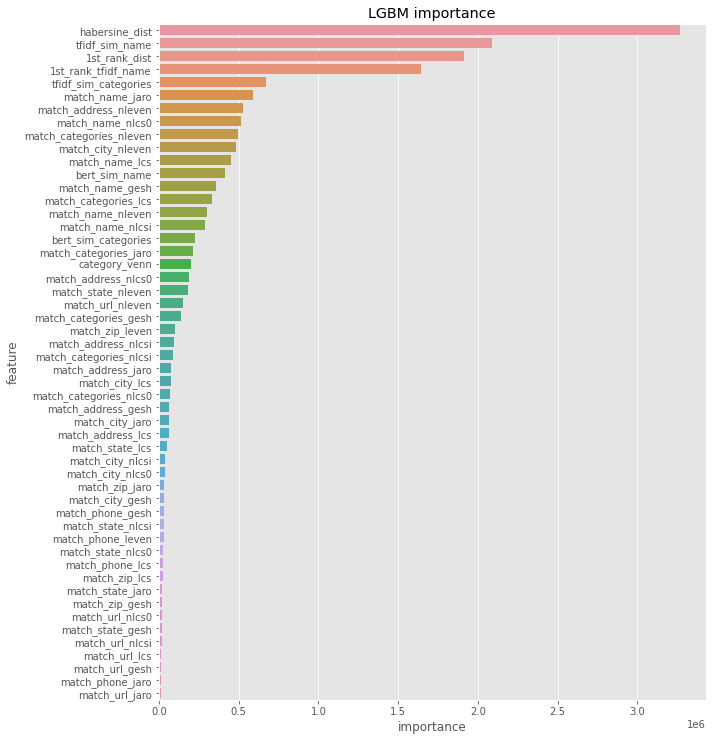

In [90]:
%%time
train_origin = pd.read_csv(INPUT_DIR + "train.csv")
train_origin = preprocess(train_origin)

# trainデータの分割
kf = GroupKFold(n_splits=2)
for i, (trn_idx, val_idx) in enumerate(kf.split(train_origin, train_origin['point_of_interest'], train_origin['point_of_interest'])):
    train_origin.loc[val_idx, "set"] = i
# cv用にデータ分割
test_origin = train_origin[train_origin["set"]==1].copy()
test_origin = test_origin.reset_index(drop=True)
train_origin = train_origin[train_origin["set"]==0].copy()
train_origin = train_origin.reset_index(drop=True)

# 1st stage
dist_candidate = extract_candidate_dist(train_origin)
tfidf_name_candidate = extract_candidate_tfidf_sim(train_origin, "name")
train = pd.concat([dist_candidate, tfidf_name_candidate])
train = train.drop_duplicates(subset=["id", "match_id"])
train = train.reset_index(drop=True)

dist_candidate["1st_rank_dist"] = dist_candidate.groupby("id").cumcount()
tfidf_name_candidate["1st_rank_tfidf_name"] = tfidf_name_candidate.groupby("id").cumcount()
train = train.merge(dist_candidate[["id", "match_id", "1st_rank_dist"]], on=["id", "match_id"], how="left")
train = train.merge(tfidf_name_candidate[["id", "match_id", "1st_rank_tfidf_name"]], on=["id", "match_id"], how="left")
del dist_candidate, tfidf_name_candidate
gc.collect()

train = add_orgin_data(train, train_origin)

stage1_max_score = calc_max_score(train, train_origin)

# 2nd stage
train["habersine_dist"] = haversine_np(train["longitude"], train["latitude"], train["match_longitude"], train["match_latitude"])

# create target
train['target'] = (train['point_of_interest'] == train['match_point_of_interest']).values.astype(int)
train["target"] = train["target"].fillna(0)

train = add_distance_features(train)
train["category_venn"] = train[["categories", "match_categories"]].apply(lambda row: categorical_similarity(row.categories, row.match_categories), axis=1)

# reduce memory
train = train.drop(columns=['latitude', 'longitude', 'address', 'city', 'state', 'zip', 'country', 'url', 'phone',
                            'match_latitude', 'match_longitude', 'match_address', 'match_city', 'match_state', 
                            'match_zip', 'match_country', 'match_url', 'match_phone'])
gc.collect()

# bert類似度
bert_vec_categories = make_bert_vec(train_origin[["categories"]], "categories")
train = add_vec_sim_features(train, bert_vec_categories, "bert", "categories")
del bert_vec_categories
gc.collect()

print("add_bert_sim_name")
bert_vec_name = make_bert_vec(train_origin[["name"]], "name")
train = add_vec_sim_features(train, bert_vec_name, "bert", "name")
del bert_vec_name
gc.collect()

# universal sentence類似度
#univ_vec_name = make_univ_vec(train_origin[["name"]], "name")
#train = add_vec_sim_features(train, univ_vec_name, "univ", "name")
#del univ_vec_name
#gc.collect()


not_use_cols = ['match_state_leven', 'address', 'categories', 'point_of_interest', 'match_address_leven',
                'city', 'match_point_of_interest', 'match_name', 'match_categories_leven', 'match_longitude',
                'target', 'match_city_leven', 'zip', 'match_categories', 'match_city', 'match_latitude',
                'match_zip', 'match_url', 'id', 'match_set', 'country', 'match_state', 'match_address',
                'match_name_leven', 'match_id', 'latitude', 'url', 'set', 'name', 'phone', 'longitude',
                'match_url_leven', 'state', 'match_phone', 'match_country']
features = [c for c in train.columns if c not in not_use_cols]
#with open(OUTPUT_DIR + f'{exp_name}/features.pickle', 'wb') as f:
#    pickle.dump(features, f)

train = reduce_data_size(train, features)

model = train_model(train, features, cv=True)

# 評価

In [91]:
%%time
# 1st stage
# 1st stage
dist_candidate = extract_candidate_dist(test_origin)
tfidf_name_candidate = extract_candidate_tfidf_sim(test_origin, "name")
test = pd.concat([dist_candidate, tfidf_name_candidate])
test = test.drop_duplicates(subset=["id", "match_id"])
test = test.reset_index(drop=True)

dist_candidate["1st_rank_dist"] = dist_candidate.groupby("id").cumcount()
tfidf_name_candidate["1st_rank_tfidf_name"] = tfidf_name_candidate.groupby("id").cumcount()
test = test.merge(dist_candidate[["id", "match_id", "1st_rank_dist"]], on=["id", "match_id"], how="left")
test = test.merge(tfidf_name_candidate[["id", "match_id", "1st_rank_tfidf_name"]], on=["id", "match_id"], how="left")
del dist_candidate, tfidf_name_candidate
gc.collect()

test = add_orgin_data(test, test_origin)

# 2nd stage
test["habersine_dist"] = haversine_np(test["longitude"], test["latitude"], test["match_longitude"], test["match_latitude"])

# create target
test['target'] = (test['point_of_interest'] == test['match_point_of_interest']).values.astype(int)
test["target"] = test["target"].fillna(0)

test = add_distance_features(test)
test["category_venn"] = test[["categories", "match_categories"]].apply(lambda row: categorical_similarity(row.categories, row.match_categories), axis=1)

# reduce memory
test = test.drop(columns=['latitude', 'longitude', 'address', 'city', 'state', 'zip', 'country', 'url', 'phone',
                            'match_latitude', 'match_longitude', 'match_address', 'match_city', 'match_state', 
                            'match_zip', 'match_country', 'match_url', 'match_phone'])
gc.collect()

# bert類似度
bert_vec_categories = make_bert_vec(test_origin[["categories"]], "categories")
test = add_vec_sim_features(test, bert_vec_categories, "bert", "categories")
del bert_vec_categories
gc.collect()

print("add_bert_sim_name")
bert_vec_name = make_bert_vec(test_origin[["name"]], "name")
test = add_vec_sim_features(test, bert_vec_name, "bert", "name")
del bert_vec_name
gc.collect()

# universal sentence類似度
#univ_vec_name = make_univ_vec(test_origin[["name"]], "name")
#test = add_vec_sim_features(test, univ_vec_name, "univ", "name")
#del univ_vec_name
#gc.collect()


not_use_cols = ['match_state_leven', 'address', 'categories', 'point_of_interest', 'match_address_leven',
                'city', 'match_point_of_interest', 'match_name', 'match_categories_leven', 'match_longitude',
                'target', 'match_city_leven', 'zip', 'match_categories', 'match_city', 'match_latitude',
                'match_zip', 'match_url', 'id', 'match_set', 'country', 'match_state', 'match_address',
                'match_name_leven', 'match_id', 'latitude', 'url', 'set', 'name', 'phone', 'longitude',
                'match_url_leven', 'state', 'match_phone', 'match_country']

test = reduce_data_size(test, features)

model.save_model(OUTPUT_DIR + f"{exp_name}/cv_model.lgb")
pred = np.zeros(len(test))
fi = ForestInference()
fi = ForestInference.load(OUTPUT_DIR + f"{exp_name}/cv_model.lgb", output_class=True, model_type="lightgbm")
pred += fi.predict(test[features])
test["prob"] = pred

test = transform_data(test, test_origin)
test = postprocess(test)

score = get_score(test, test_origin)
print(f'cv_score = ' + '{:.5f}'.format(score))

test.to_csv(OUTPUT_DIR + f"{exp_name}/cv_oof.csv", index=False)

100%|██████████| 211/211 [00:39<00:00,  5.28it/s]
203it [33:02,  9.77s/it] 
Some weights of the model checkpoint at distilbert-base-multilingual-cased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 9907490/9907490 [02:48<00:00, 58856.33it/s] 


add_bert_sim_name


Some weights of the model checkpoint at distilbert-base-multilingual-cased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 9907490/9907490 [03:19<00:00, 49725.38it/s]


[W] [05:13:37.512746] Treelite currently does not support float64 model parameters. Accuracy may degrade slightly relative to native LightGBM invocation.
[W] [05:13:42.300355] Casting all thresholds and leaf values to float32, as FIL currently doesn't support inferencing models with float64 values. This may lead to predictions with reduced accuracy.


/opt/conda/lib/python3.8/site-packages/cupy/_creation/from_data.py:66: PerformanceWarning: Using synchronous transfer as pinned memory (2060757920 bytes) could not be allocated. This generally occurs because of insufficient host memory. The original error was: cudaErrorMemoryAllocation: out of memory
  return _core.array(a, dtype, False, order)
100%|██████████| 569406/569406 [00:00<00:00, 757184.89it/s]


cv_score = 0.86024
CPU times: user 12min 59s, sys: 31.4 s, total: 13min 31s
Wall time: 45min 50s


In [92]:
report = f'{exp_name}\n'
report += memo + '\n'
report += 'stage1_max_score : ' + '{:.5f}'.format(stage1_max_score) + '\n'
report += 'cv_score : ' + '{:.5f}'.format(score) + '\n'
print(report)
line_notify.send(report)
slack_notify.send(report)

exp045
exp043 + 特徴量に1stのrank追加
stage1_max_score : 0.95871
cv_score : 0.86024

